# Evaluating New Marketing Campaign Performance (AB Testing)

## Introduction

This project analyzes the performance of a new marketing campaign in comparison to the old one. The goal is to test if using the new marketing campaign is more effective at drawing customers to the site (i.e. it has a higher conversion rate), and if so, if the findings are statistically significant.

**Dataset Source**: Randomly generated AB test data. The dataset I use in this analysis is contained within this GitHub repository under "ab_test_data.csv." If you would like to generate your own test data to do your own analysis with, the Python code for generating a similar CSV is in the "email_ab_testing.ipynb" notebook. 

**Time Period:** March 1, 2025 to March 31, 2025. However, randomly generated data contains completely random timestamps; there should be no consideration given to seasonality or times of increased activity. This analysis only slightly touches upon time-conversion analysis, just to practice for real-world situations.

**Tools Used:** numpy, pandas, scipy, statsmodels, matplotlib, seaborn

## Setup

For this analysis, we are following a model situation that may be conducted in real-world business settings. We are assuming that a marketing team has come to us for help in designing a new marketing email. From our current research into customer habits, we know that the current conversion rate (the rate that customers take a desired action, in this case clicking the link in the email) is **0.08**. So, 8% of the people receiving the current version of the email click the link to proceed to our website's landing page. The marketing team has been designing a new version of the email that includes less text and more visuals. They hope that this new version of the email will show a conversion rate of at least **0.1**, and ask us to design an experiment to check this assumption.

## Importing Libraries

We begin by importing all the libraries necessary for our analysis.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Designing the Experiment

Before any testing is done, we must know the sufficient sample sizes to be able to draw the conclusions we are looking for. We will assume that our website gets around 10,000 visitors per month. 

We will set statistical power to 0.8, alpha to 0.05, and the ratio to 1. These are all very standard settings for sample size calculations.

Basically, the power is the probability of detecting an effect in a test, given it exists -- in our case, this is the probability of detecting a difference between conversion rates of the groups being tested. 

Alpha is the probability of obtaining our results due to pure chance, so we want to keep this as low as possible. In our case, the alpha is saying that we are okay with a 5% chance of our results being due to pure chance.

The ratio here is the ratio of treatment to control group size. We want the groups to be equal, so the ratio will be set at 1.

In [3]:
# define expected difference between groups
effect_size = sms.proportion_effectsize(0.08, 0.1)

# find required number of sample points
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1 # equal-sized control/treatment groups
    )

# round up
required_n = ceil(required_n)

print(required_n)

3205


So, we need 3205 people in our treatment group and 3205 people in our control group, or 6410 customers in total to run the test according to our desired statistical parameters.

We have now set up the experiment and can begin to record metrics. We will run this test for one month, from March 1, 2025 to March 31, 2025, and collect information on 5 variables for each observation. These will be:
* user_id = the id of the user
* timestamp = when the email was accessed by the user
* group = treatment or control group
* email_version = version of the email received (new/old)
* converted = whether the recipient clicked through to get to our landing page

## Data Loading and Preprocessing

We begin by loading in the data and checking the first few rows, as well as some basic information.

In [4]:
df = pd.read_csv('ab_test_data.csv')

df.head()

,user_id,timestamp,group,email_version,converted
0,1908,2025-03-26 06:04:09,treatment,new,0
1,571,2025-03-28 12:43:25,control,old,0
2,412,2025-03-14 18:26:57,control,old,0
3,6637,2025-03-06 06:33:45,control,old,0
4,5839,2025-03-07 07:34:41,control,old,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        10000 non-null  int64 
 1   timestamp      10000 non-null  object
 2   group          10000 non-null  object
 3   email_version  10000 non-null  object
 4   converted      10000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


In [6]:
df.shape

(10000, 5)

Now, we will count if there are any duplicate users recorded in our dataset by checking the appearances of each unique user_id.

In [7]:
# count the number of appearances of each userid in the dataset
session_counts = df['user_id'].value_counts(ascending=False)

# count the number of userids that appear more than once
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


## Gathering the Sample

Now, we will gather the required sample sizes according to our statistical parameters, and create a new dataframe with just these observations.

In [8]:
# sample from the control
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)

# sample from the treatment
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

# combine the two samples
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [9]:
ab_test.shape

(6410, 5)

We have now created our dataset with 6410 observations, exactly the minimum we need to run the test we previously designed.

We will now check each of the groups to ensure that they were split properly.

In [10]:
# check number of observations for each group
ab_test['group'].value_counts()

group
control      3205
treatment    3205
Name: count, dtype: int64

The split of the groups between treatment and control looks good. 

## Calculating Conversion Rates

We will proceed to calculate the conversion rate for each group, along with their standard deviations and errors.

A difference in conversion rates will imply that the email version impacts conversion rate; we will then check their standard deviations and standard errors. The standard deviation is a measure of how dispersed the data in our sample is, on average; and the standard error tells us how much our sample data represents the population (smaller is better).

In [12]:
# separate groups and select the converted column from each
conversion_rates = ab_test.groupby('group')['converted'].agg(
    conversion_rate='mean',
    std_deviation=lambda x: np.std(x, ddof=1),
    std_error=lambda x: np.std(x, ddof=1) / np.sqrt(len(x))
)

# Display with formatting
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.083,0.276,0.005
treatment,0.115,0.320,0.006


Our conversion rates look to be different from each other, implying that email version impacts conversion rate. Further, the standard deviations are perfectly normal -- for a Bernoulli distribution (binary outcomes, like in the case of converted vs. did not convert), the standard deviations fall between 0 and 0.5. So, the standard deviations of 0.276 and 0.320 for the control and treatment groups respectively fall right in the middle of the range. Finally, our standard errors are quite small, which implies that our samples accurately represent the larger population of email recipients.

## Testing Significance of Findings

We will now perform some significance tests to check if our findings are statistically significant. First, we will calculate the z-score, which basically cheks that the mean of the two datasets (treatment vs. control, here) is big enough that the results are very unlikely to be due to pure chance. Then, we will calculate the p-value, which basically states how likely your z-score would be if there really was no difference between groups. Finally, We will calculate 95% confidence intervals, which are basically stating the range of values we believe (with 95% certaintly) contains the true conversion rate.

In [14]:
# create series of conversion results (0s and 1s for each group)
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

# count number of obs in each group
n_con = control_results.count()
n_treat = treatment_results.count()

# find sums of conversions
successes = [control_results.sum(), treatment_results.sum()]

# list of total obs in each group
nobs = [n_con, n_treat]

# find zstat and pval
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# 95% confints for each group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

# print results
print(f'z-score: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% CI for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% CI for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z-score: -4.30
p-value: 0.000
95% CI for control group: [0.074, 0.093]
95% CI for treatment group: [0.104, 0.127]


Our results showed that our findings are statistically significant. A z-score of -4.3 and p-value of 0.000 states that our findings are very unlikely to be do to pure chance; the confidence intervals show no overlap in number, concluding that even with standard deviation/randomness, there is a true difference in the conversion rates between groups.

## Visualization of Results

Finally, we will create some visualizations to share with the stakeholders and marketing team, for easy and quick communication of findings.

First, we will visualize the conversion rate by group (control vs. treatment).

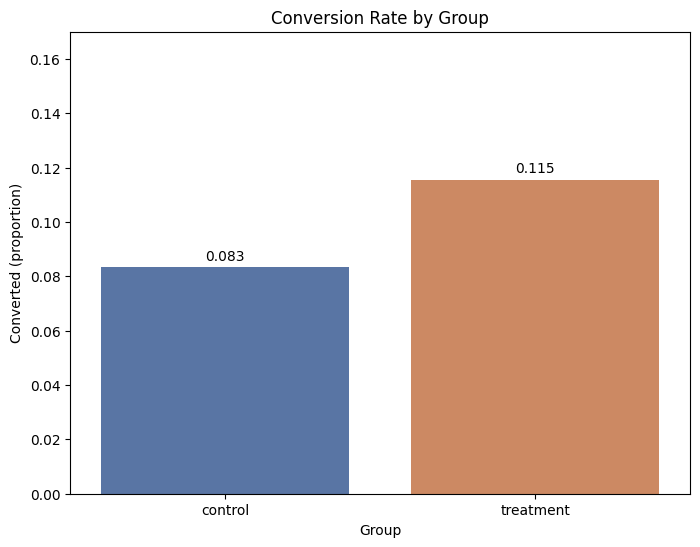

In [31]:
# visualize results

plt.figure(figsize=(8,6))
plt.style.use('seaborn-v0_8-pastel')

ax = sns.barplot(
    x='group',
    y='converted',
    hue='group',
    data=ab_test,
    errorbar=('ci', False),
    palette=['#4c72b0', '#dd8452'], 
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.ylim(0, 0.17)
plt.title('Conversion Rate by Group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)')
plt.show()


As you can see, there is a clear visual difference between the conversion rates.

Next, we will create a bar chart of each group, showing the actual number of conversions within the total sample numbers for each group.

Text(0.5, 1.0, 'Distribution of Converted Users by Group')

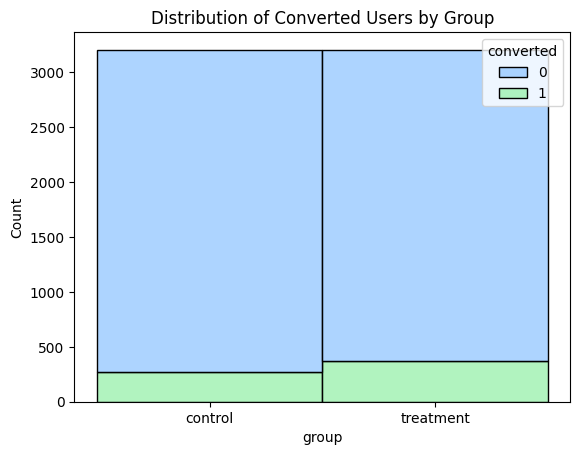

In [67]:
sns.histplot(ab_test, x='group', hue='converted', multiple='stack', binwidth=0.1)
plt.title("Distribution of Converted Users by Group")

As you can see, slightly more people in the treatment group converted when compared to the control group.

We will now display a line graph of daily conversion rate over time. Note that this should not be taken as significant, as the data were generated randomly with respect to the date. This is just for practice in real-world situations in which time-series analysis may be important.

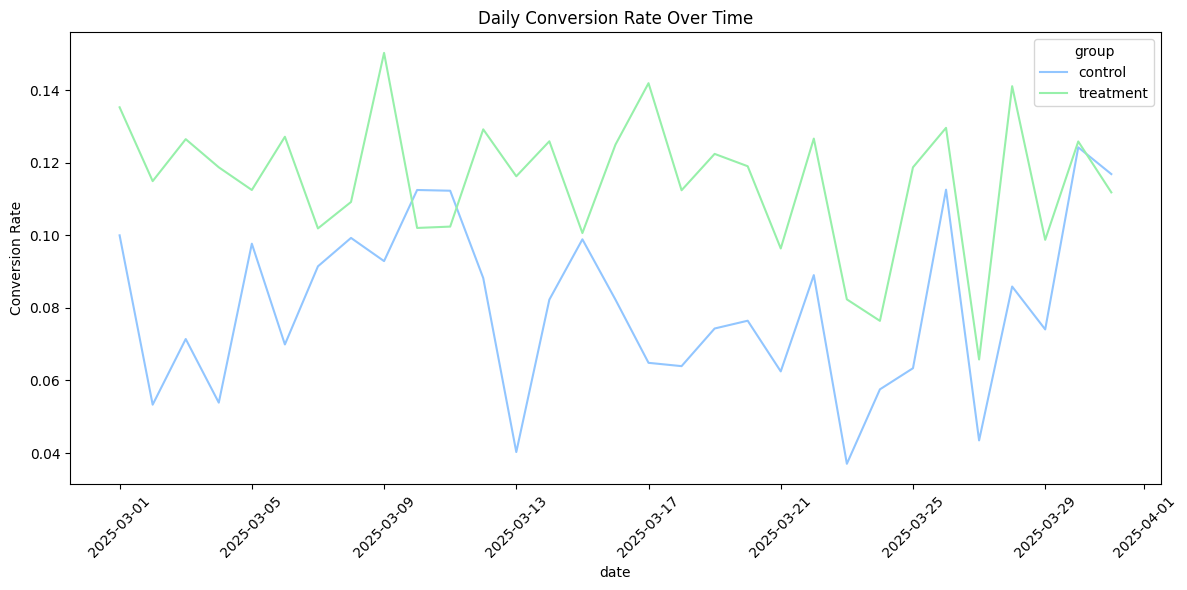

In [80]:
# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# create new df with just the date
df['date'] = df['timestamp'].dt.date

# group by group 
daily_cr = df.groupby(['date', 'group'])['converted'].mean().reset_index()

# plot
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_cr, x='date', y='converted', hue='group')
plt.title('Daily Conversion Rate Over Time')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Now we will plot the treatment and control groups with the 95% confidence interval bars.

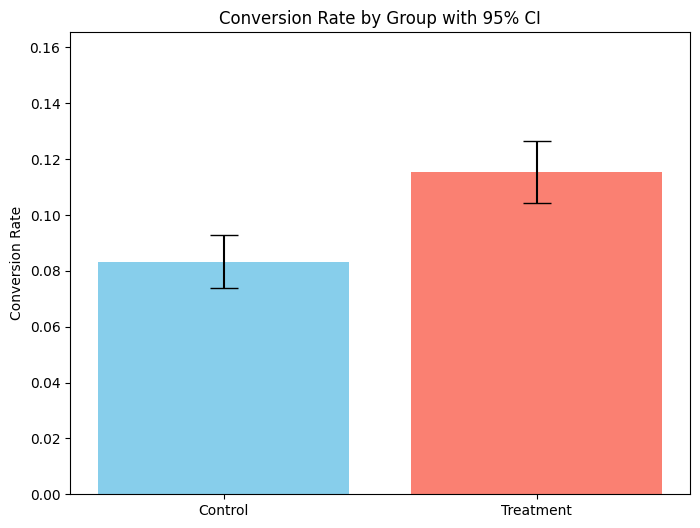

In [45]:
plt.figure(figsize=(8,6))
plt.bar(['Control', 'Treatment'],
        [control_results.mean(), treatment_results.mean()],
        yerr=[
            1.96 * control_results.std(ddof=0) / (n_con ** 0.5),
            1.96 * treatment_results.std(ddof=0) / (n_treat ** 0.5)
        ],
        capsize=10,
        color=['skyblue', 'salmon'])

plt.title('Conversion Rate by Group with 95% CI')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(control_results.mean(), treatment_results.mean()) + 0.05)
plt.show()


As evidenced in the bar chart, the error bars do not overlap. This means that the conversion rates are truly different (from a statistical standpoint), even when considering variability/randomness.

Now we will visualize the results of the z-test. We will show:
* The normal distribution, as our sample is large enough to approximate using the central limit theorem,
* The rejection regions, the spots under the curve where you can confidently say that there is a difference in conversion rates,
* And the z-score, the number which determines if we can determine true differences between the groups (depending on where it falls)

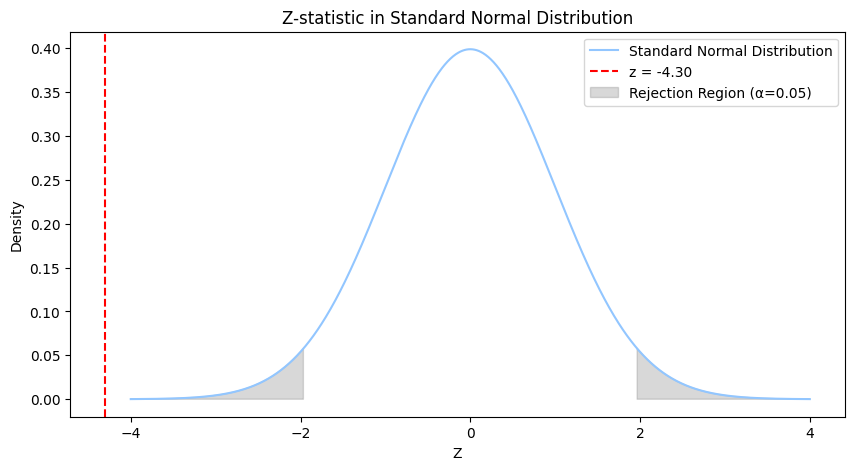

In [84]:
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Standard Normal Distribution')
plt.axvline(x=z_stat, color='red', linestyle='--', label=f'z = {z_stat:.2f}')
plt.fill_between(x, y, where=(x < -1.96) | (x > 1.96), color='gray', alpha=0.3, label='Rejection Region (α=0.05)')
plt.title('Z-statistic in Standard Normal Distribution')
plt.xlabel('Z')
plt.ylabel('Density')
plt.legend()
plt.show()


As you can see, the z-score is very deep into the left rejection region. This means that we can "reject" the null hypothesis, which is basically the assumption that there is no difference between groups (this is part of the experimental process).

Finally, we will visualize the confidence intervals themselves on a number line.

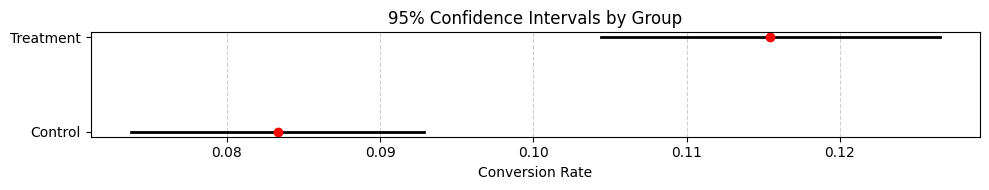

In [85]:
import matplotlib.pyplot as plt

# Labels and values
groups = ['Control', 'Treatment']
means = [control_results.mean(), treatment_results.mean()]
ci_lower = [lower_con, lower_treat]
ci_upper = [upper_con, upper_treat]

# Plot
plt.figure(figsize=(10, 2))
for i in range(len(groups)):
    plt.plot([ci_lower[i], ci_upper[i]], [i, i], color='black', linewidth=2)  # CI line
    plt.plot(means[i], i, 'o', color='red')  # Mean point

plt.yticks([0, 1], groups)
plt.xlabel('Conversion Rate')
plt.title('95% Confidence Intervals by Group')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


According to the graph, the confidence intervals do not overlap, and their means are far enough apart to show a moderate difference in conversion rate.

## Conclusion

In conclusion, our marketing team's newest email design was shown to cause an increase in conversion rate, from 0.08 to 0.1. The findings were statistically significant, with a z-score of -4.3, a p-value of 0, and non-overlapping 95% confidence intervals: [0.074, 0.093] for the control group, and [0.104, 0.127] for the treatment group. 

Our test was a success, and we should use the new email design in all emails going forward. To increase the conversion rate further, we can just conduct more A/B tests as we see fit; it is a continuing process!